In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import json 
import random
import requests as rq
from time import sleep

from string import ascii_lowercase, digits, ascii_letters

import multiprocessing as mp
from tqdm import tqdm
import asyncio
import concurrent.futures
import pandas as pd

In [4]:
url = "http://pyapi.godatadriven.com"
username = "VinDiesel"
alphabet = ascii_lowercase + digits

In [5]:
def submit_random(user_name):
    cypher = "".join(random.sample("qwertyuiplkjhgfdsazxcvbnmo0123456789", 36))
    payload = {"user": username, "cypher": cypher}
    headers = {'content-type': 'application/json'}
    resp = rq.request("POST", url, data=json.dumps(payload), headers=headers)
    return resp.json()

In [6]:
submit_random(username)

{'identifier': '47580a99-42a4-407c-9ea3-2010d7aad808',
 'score': 0.14133642439817518,
 'status': 'succes',
 'timestamp': '2019-07-14 01:04:35.155651',
 'user': 'VinDiesel'}

In [6]:
dummy = {'identifier': '081a566b-6b5a-4505-9c36-89332cf021e9',
 'score': 0.0,
 'status': 'succes',
 'timestamp': '2019-07-14 01:03:18.635351',
 'user': 'VinDiesel'}

In [7]:
def submit(cypher):
    payload = {"user": username, "cypher": cypher}
    headers = {'content-type': 'application/json'}
    try:
        resp = rq.request("POST", url, data=json.dumps(payload), headers=headers)
    except:
        return dummy
    
    r = resp.json()
    r['sample'] = cypher
    return r

### Caesar shifts

In [5]:
caesarshifts = [alphabet[k:] + alphabet[0:k] for k in range(len(alphabet))]

In [6]:
caesar_res = []
for c in caesarshifts:
    res = submit(c)
    caesar_res.append(res)

KeyboardInterrupt: 

In [49]:
caesar_score = [res['score'] for res in caesar_res]

In [51]:
max(caesar_score)

0.18021351303707936

### Fix first char and sample all the rest

In [179]:
n_samples = 1
fix_first = []

for char in alphabet:
    strings = []
    for n in range(n_samples):
        string = char + ''.join(random.sample(alphabet.replace(char, ''), 35))
        strings.append(string)
    fix_first = fix_first + strings

In [180]:
len(fix_first)

36

In [181]:
res = []

In [8]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [9]:
async def submit_async(samples):
    with ThreadPoolExecutor(max_workers=20) as executor:
        
        loop = asyncio.get_event_loop()
        futures = [
            loop.run_in_executor(
                executor,
                submit,
                sample
            )
            for sample in samples
        ]
        
        # get results
        for resp in await asyncio.gather(*futures):
            
            #resp['sample'] = sample
            results.append(resp)

In [184]:
loop = asyncio.get_event_loop()
loop.run_until_complete(submit_async(fix_first))

NameError: name 'results' is not defined

In [35]:
scores = [r['score'] for r in res]

In [36]:
max(scores)

0.38434421805877667

In [37]:
res

[{'identifier': '46b00b40-f551-4b72-b8f8-284cf29a0a33',
  'score': 0.19736779298815038,
  'status': 'succes',
  'timestamp': '2019-07-13 20:40:23.218057',
  'user': 'VinDiesel',
  'sample': 'axd9p8t2kuim635f1b0vrzyc4lengjowq7hs'},
 {'identifier': '5bb77524-e628-4dea-a022-aa21a5b106eb',
  'score': 0.2328976590256116,
  'status': 'succes',
  'timestamp': '2019-07-13 20:40:23.352841',
  'user': 'VinDiesel',
  'sample': 'azr4js32k8vthcy5qfxmu01eio6bnp79dwgl'},
 {'identifier': '8e0f010a-fb78-42ba-b462-fc2edb823b68',
  'score': 0.17104682022613907,
  'status': 'succes',
  'timestamp': '2019-07-13 20:40:23.357269',
  'user': 'VinDiesel',
  'sample': 'achijqyf8mpxodkugvs70elw53r619tb4zn2'},
 {'identifier': 'c6a8ec41-2d5b-41c0-a40e-26b0cce2cc38',
  'score': 0.23982157297796974,
  'status': 'succes',
  'timestamp': '2019-07-13 20:40:23.343041',
  'user': 'VinDiesel',
  'sample': 'ato6qrlb02su19hy7d54zjfwnkeg8ixmpcv3'},
 {'identifier': 'f82cf410-5543-4923-b758-05edf7bddf61',
  'score': 0.23123059

In [38]:
with open('data/fix_first_100.json', 'w') as fp:
    json.dump(res, fp)

In [39]:
start_letter = [r['sample'][0] for r in res]
score = [r['score'] for r in res]

In [40]:
df = pd.DataFrame({'start_letter':start_letter,
                   'score': score})

In [41]:
grouped = df.groupby('start_letter').agg([np.mean, np.std])

In [48]:
grouped.head()

score          
                  mean       std
start_letter                    
0             0.179173  0.051514
1             0.185580  0.058577
2             0.194134  0.056720
3             0.182024  0.064009
4             0.187092  0.046605

<ErrorbarContainer object of 3 artists>

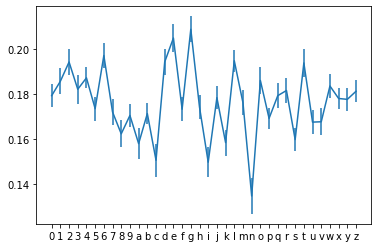

In [56]:
plt.errorbar(grouped.index, grouped.score['mean'], grouped.score['std']/np.sqrt(100))

### evol

In [10]:
def random_start():
    return ''.join(random.sample(alphabet, 36))

In [11]:
def func_to_optimize(cypher):
    res = submit(cypher)
    return res['score']

In [12]:
def pick_random_parents(pop):
    mom = random.choice(pop)
    dad = random.choice(pop)
    return mom, dad

In [13]:
def make_child(mom, dad):
    child = mom[:18] + dad[18:]
    return child

In [14]:
def add_noise(chromosome, sigma=3):
    ls = list(chromosome)
    
    swaps = [(random.randint(0, 35), random.randint(0, 35)) for _ in range(sigma)]
    for swap in swaps:
        ls[swap[0]], ls[swap[1]] = ls[swap[1]], ls[swap[0]]
    
    new = ''.join(ls)
    return new

In [120]:
from evol import Population, Evolution

In [130]:
N = 10

In [131]:
pop = Population(chromosomes=[random_start() for _ in range(N)],
                eval_function=func_to_optimize, maximize=True)

In [132]:
evo1 = (Evolution()
        .survive(fraction=0.5)
        .breed(parent_picker=pick_random_parents, combiner=make_child)
        .mutate(mutate_function=add_noise))

In [133]:
evo2 = (Evolution()
       .survive(n=1)
       .breed(parent_picker=pick_random_parents, combiner=make_child)
       .mutate(mutate_function=add_noise))

In [134]:
pop = pop.evolve(evo1, n=5)

### home-grown genetic algo

In [60]:
NPOP = 100
FRAC_SURVIVE = 0.1
NOISE = 15
RATE = 0.5

EPOCHS = 5000

In [16]:
def random_pop():
    return [random_start() for _ in range(NPOP)]

In [17]:
def partition(lst, n_crossover):
    division = len(lst) / n_crossover
    return [lst[round(division * i):round(division * (i + 1))] for i in range(n_crossover)]

def crossover_ox(mom_order, dad_order, n_crossover):
    idx_split = partition(range(len(mom_order)), n_crossover=n_crossover)
    dad_idx = sum([list(d) for i, d in enumerate(idx_split) if i % 2 == 0], [])
    path = [-1 for _ in range(len(mom_order))]
    for idx in dad_idx:
        path[idx] = dad_order[idx]
    cities_visited = {p for p in path if p != -1}
    for i, d in enumerate(path):
        if d == -1:
            city = [p for p in mom_order if p not in cities_visited][0]
            path[i] = city
            cities_visited.add(city)
    return ''.join(path)

In [18]:
def crossover_rand(mom, dad):
    pass

In [51]:
crossover_ox(alphabet, alphabet[::-1], 18)

'98ab54ef10ijxwmntsqrpouvlkyzhg23dc67'

In [20]:
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789'

In [21]:
alphabet[::-1]

'9876543210zyxwvutsrqponmlkjihgfedcba'

In [22]:
def crossover_uniform(mom, dad):
    parents = (mom, dad)
    child = []
    for i in range(len(mom)):
        parent = random.randint(0, 1)
        child.append(parents[parent][i])
    
    return ''.join(child)

In [23]:
def pick_best(res, npop=NPOP, fraction=FRAC_SURVIVE):
    pdres = pd.DataFrame.from_records(res)
    best = pdres.nlargest(int(npop*fraction), columns=['score'])
    return best['sample'].tolist()

In [24]:
def evolve(best, npop=NPOP, fraction=FRAC_SURVIVE, strategy='uniform'):
    n = int(npop - int(npop*fraction))
    evolved = []
    
    while len(evolved) < n:
    #for i in range(n):
        mom = random.choice(best)
        dad = random.choice(best)

        if strategy=='uniform':
            child = crossover_uniform(mom, dad)
        elif isinstance(strategy, int):
            child = crossover_ox(mom, dad, strategy)
        else:
            print('Unknown strategy, concatenating')
            child = mom[:18] + dad[18:]
        # avoid converging to identical population
        #if child not in evolved:
        evolved.append(child)
    
    return evolved

In [59]:
def mutate(pop, noise=NOISE, rate=RATE):
    for ix, p in enumerate(pop):
        
        # small mutation rate
        if random.random() < rate:
        
            ls = list(p)
            n_swaps = random.randint(0, noise)
            #n_swaps = noise

            swaps = [(random.randint(0, 35), random.randint(0, 35)) for _ in range(n_swaps)]

            for swap in swaps:
                ls[swap[0]], ls[swap[1]] = ls[swap[1]], ls[swap[0]]

            new = ''.join(ls)
            pop[ix] = new
    
    return pop

In [26]:
def add_noise(chromosome, sigma=3):
    ls = list(chromosome)
    
    swaps = [(random.randint(0, 35), random.randint(0, 35)) for _ in range(sigma)]
    for swap in swaps:
        ls[swap[0]], ls[swap[1]] = ls[swap[1]], ls[swap[0]]
    
    new = ''.join(ls)
    return new

In [61]:
from collections import Counter

In [62]:
pop = random_pop()

In [63]:
best_scores = []

In [64]:
len(pop)

100

In [68]:
pop76 = pop.copy()

In [ ]:
NOISE = 20
RATE = 1
ATTEMPT=32
loop = asyncio.get_event_loop()

for e in tqdm(range(EPOCHS)):
    results = []
    loop.run_until_complete(submit_async(pop))
    
    with open('data/evol{}_epoch_{}.json'.format(e, ATTEMPT), 'w') as fp:
        json.dump(results, fp)
    
    try:
        scores = [res['score'] for res in results]
        max_score = max(scores)
        ix = np.argmax(scores)
        ixs = np.argsort(scores)[::-1]
        
        best_scores.append(max_score)
        print('Epoch {}, best candidate: {}'.format(e, max_score))
        for ix, i in enumerate(ixs[:3]):
            print('{}th: {}, score {}'.format(ix, results[i]['sample'], results[i]['score']))
        
        n_unique = len(Counter(pop).values())
        print('Number of unique individuals in pop: {}'.format(n_unique))
    except:
        pass
    
    best = pick_best(results)
    evol = evolve(best, strategy=18)
    pop = best + evol
    print('Epoch: {}, pop: {}, best: {}, evol: {}'.format(e, len(pop),
                                                         len(best), len(evol)))
    pop = mutate(pop)



  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 1/5000 [00:56<78:24:05, 56.46s/it]

Epoch 0, best candidate: 0.7619465121335527
0th: ezbjktg6l210qwo4pyxm5379usfvr8hcdain, score 0.7619465121335527
1th: ezbjktg6l210qwo4pyxm5379usfvr8hcdain, score 0.7618989687210933
2th: ezbjktg6l210qwo4pyxm5379usfvr8hcdain, score 0.761439086214546
Number of unique individuals in pop: 47
Epoch: 0, pop: 100, best: 10, evol: 90


In [66]:
pop

['ezbjktg6l210qwo4pyxm5379usfvr8hcdain',
 'ezbjktg6l210qwo4pyxm5379usfvr8hcdain',
 'ezbjktg6l210qwo4pyxm5379usfvr8hcdain',
 'ezbjktg6l210qwo4pyxm5379usfvr8hcdain',
 'ezbjktgdl210qwo4pyxm5379usfv68hcrain',
 'vzrjktg6lb1hqpo4wyxm5379usfed80c2ain',
 'exbjkig6l210q7o4pyzm53w9usfvr8hcdatn',
 'ezbjktg6l210qwo4pyxm5379usfvr8hcdain',
 'zebjktgml610wqo4pyn25379usfhxrvciad8',
 'ezbjktg6l210qwo4pyxm5379usfvr8hcdain',
 'ezbjktg6l210qwo4pyxm5379usfvr8hcdain',
 'ezbjktg6l210qwo4pyxm5379usfvr8hcdain',
 'ezbjktg6l2i0qwo4pyxm5379usfvr8hcda1n',
 'ezbjktg6l210qwo4pyxm5379usfvr8hcdain',
 'e5bnktc6l21yqwh4p0xmz739usfvr8ogdaij',
 'ezbjktg6l210qwo4pyxm5379usfvr8hcdain',
 'ezbjk3g6l210qwo4pyxm5t79usfvr8hcdain',
 'e0bj6toal21zqwg4pycm537nukfvr8hxsdi9',
 'ezbjktg6l210qwo4pyxm5379usfvr8hcdain',
 'exbhktw6l210qgo4pyzj5379usivr8mcdafn',
 'ezbjktw6l210qgo4pyxm5as9c7fvdnhur3i8',
 'ezbjktg6l210qwo4pyxm5n79usfvr8hcdai3',
 'ezbjk6gtlc10qwo4pyxm5379usfvr8h2naid',
 'ezbjktg6l210qwo4pyxm5379usfvr8hcdain',
 'ezbjktg6l210qw

In [72]:
len(Counter(best).values())

18

In [73]:
len(best)

20

In [75]:
len(evolve)

TypeError: object of type 'function' has no len()

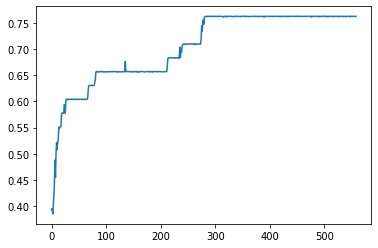

In [438]:
plt.plot(best_scores);

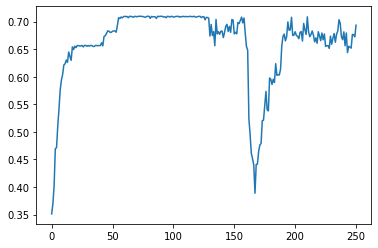

In [348]:
plt.plot(best_scores);

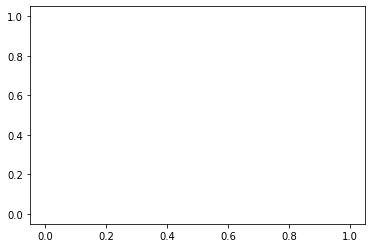

In [370]:
plt.plot(best_scores);